## Data exploration (for Calcium imaging dashboard)

This notebook is used to try out working with calcium imaging data as used in the Willuhn lab.

In [15]:
from scipy.io import loadmat
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
from math import sqrt, ceil

In [16]:
%matplotlib inline

In [17]:
data_after_CNMF_E = loadmat('data/concat_may_NoRMCorre_results.mat')

In [18]:
data_after_CNMF_E.keys()

dict_keys(['__header__', '__version__', '__globals__', 'results', '__function_workspace__'])

In [19]:
data_after_CNMF_E = data_after_CNMF_E['results']

In [20]:
print(type(data_after_CNMF_E['A'][0][0]), data_after_CNMF_E['A'][0][0].shape)
print(type(data_after_CNMF_E['C'][0][0]), data_after_CNMF_E['C'][0][0].shape)
print(type(data_after_CNMF_E['C_raw'][0][0]), data_after_CNMF_E['C_raw'][0][0].shape)

<class 'scipy.sparse.csc.csc_matrix'> (90240, 69)
<class 'numpy.ndarray'> (69, 21414)
<class 'numpy.ndarray'> (69, 21414)


In [21]:
# Extract options: (don't ask me why MATLAB stores it like this..)
options = {}

names_dict = data_after_CNMF_E['options'][0][0].dtype
names = [name for name in names_dict.fields.keys()]

for i in range(26):
    option = data_after_CNMF_E['options'][0][0][0][0][i][0]
    if(isinstance(option, str)):
        options[names[i]] = option
    elif(isinstance(option, np.ndarray)):
        options[names[i]] = option[0]
options

{'d1': 240,
 'd2': 376,
 'd3': 1,
 'ssub': 2,
 'tsub': 1,
 'init_method': 'greedy',
 'min_corr': 0.8,
 'gSig': 4,
 'gSiz': 15,
 'nb': 1,
 'nIter': 5,
 'med_app': 1,
 'save_memory': 0,
 'chunkSiz': 100,
 'windowSiz': 32,
 'snmf_max_iter': 100,
 'err_thr': 0.0001,
 'eta': 1,
 'beta': 0.5,
 'bSiz': 3,
 'maxIter': 5,
 'noise_range': 0.25,
 'noise_method': 'logmexp',
 'flag_g': 0,
 'lags': 5,
 'include_noise': 0}

In [68]:
A_df = pd.DataFrame(data_after_CNMF_E['A'][0][0].todense())
print(type(A_df), A_df.shape)
A_df.describe()
A_df.shape

<class 'pandas.core.frame.DataFrame'> (90240, 69)


(90240, 69)

In [29]:
# C_df = pd.DataFrame(data_after_CNMF_E['C'][0][0]) #really slow to load this DataFrame, use numpy instead.
# C_df.describe()
# C_df.shape

(69, 21414)

In [24]:
# C_raw_df = pd.DataFrame(data_after_CNMF_E['C_raw'][0][0]) #really slow to load this DataFrame, use numpy instead.
# C_raw_df.describe()
# C_raw_df.shape

### What I want to extract from the data for now:
- Centroid of each neuron (for calculating the distance between neurons)
- Pairwise distance between each neuron (for grouping very close/overlapping neurons, to check if they might be duplicates)
- Fluorescence trace for each neuron(for plotting a timeseries of & for calculating cross-correlation)
- Cross correlation of Fluorescence trace (for checking if there might be duplicates) (NB: VECTORISED/MATRIX)
- .tif video with cutout of each neuron (for showing a video of)

#### Centroid of each neuron (for calculating the distance between neurons)

In [65]:
number_of_pixels = A_df.shape[0]
number_of_neurons = A_df.shape[1]

df = A_df

# Keep all rows (pixels) that have non-zero values, and store their non-zero columns (neurons) and their values in a "stack"
non_zero_df = df[df!=0]
pixels_containing_neurons_stack = non_zero_df.stack()

# Select rows (pixels) that contain the column (neuron) of interest
# TODO: Factorise this?
pixels_all_neurons = []          
for i in range(number_of_neurons):
    pixels = [pixel for (pixel, neuron) in pixels_containing_neurons_stack.keys() if neuron == i]
    pixels_all_neurons.append(pixels)

# Put data in a dataframe  
# NB: this pads the shorter lists with NaNs
# TODO: Factorise this? (use numpy in 3d instead of pandas Dataframe)
df = pd.DataFrame(pixels_all_neurons)

# use dimensions d1 & d2 to figure out where the pixels are 
# TODO find out how to unpack this vector into (row,col) (even though there's padding)
d1 = options["d1"]
d2 = options["d2"]
col_df = df.apply(lambda x: x//d1)
row_df = df.apply(lambda x: x%d1)

# Calculate the mean values for the dataframe
col_df_mean = col_df.mean(axis=1)
row_df_mean = row_df.mean(axis=1)

mean_locations = []
for i in range(number_of_neurons):
    mean_locations.append((col_df_mean[i], row_df_mean[i]))
mean_locations_df = pd.DataFrame(mean_locations)

        0    1    2    3    4    5    6    7    8    9   ...   59   60   61  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
90235  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
90236  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
90237  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
90238  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
90239  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

        62   63   64   65   66   67   68  
0      0

 #### Pairwise distance between each neuron (for grouping very close/overlapping neurons, to check if they might be duplicates)

In [60]:
# Calculate pairwise euclidian distance
distance_df = pd.DataFrame(itertools.combinations(mean_locations_df.index,2), columns = ['neuron_1','neuron_2'])
distance_df['distance'] = pdist(mean_locations_df.values, 'euclid')

# Select neurons that are very close together
# TODO: write test cases to check that algorithms work as intended
small_distance = 10
neurons_close_to_another_df = distance_df[distance_df['distance'] < small_distance]
neurons_close_to_another_df

,neuron_1,neuron_2,distance
0,0,1,4.562129
3,0,4,12.706171
43,0,44,14.788501
47,0,48,6.646510
67,0,68,13.367431
70,1,4,8.802322
114,1,48,6.975530
135,2,3,0.462687
176,2,44,8.847159
185,2,53,5.890072


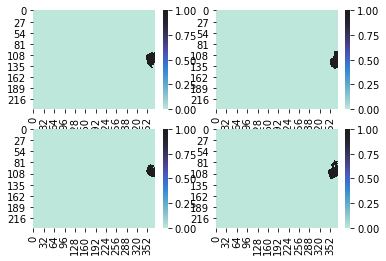

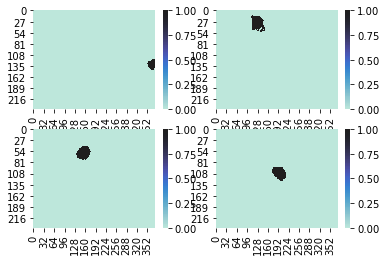

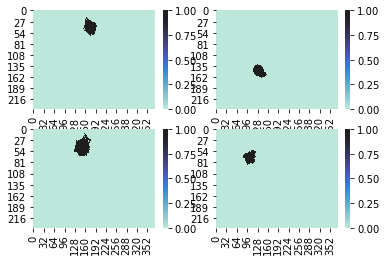

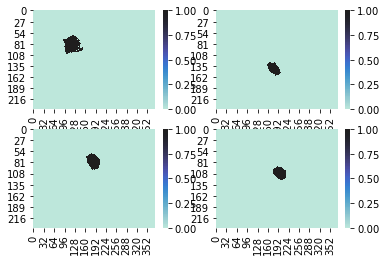

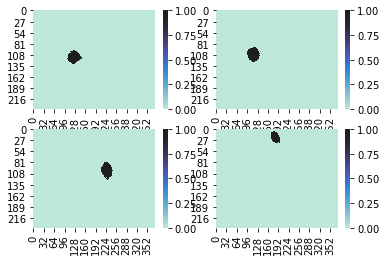

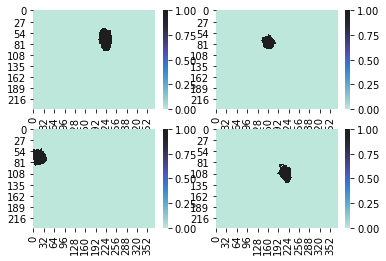

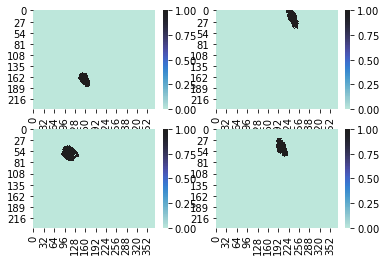

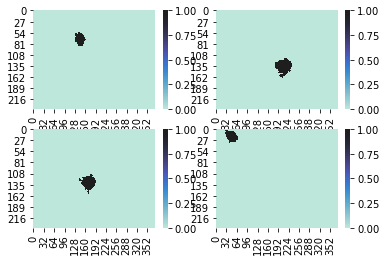

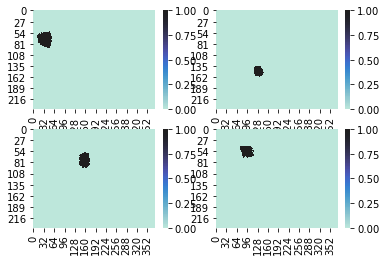

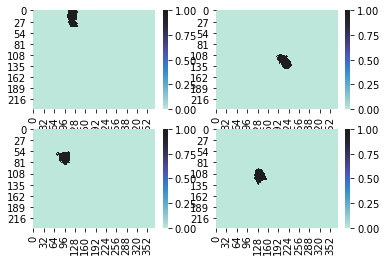

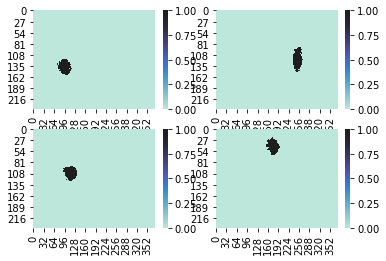

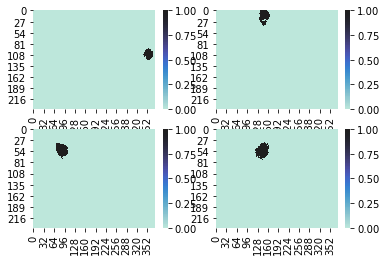

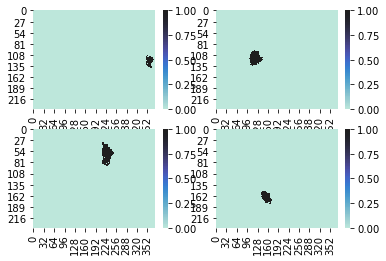

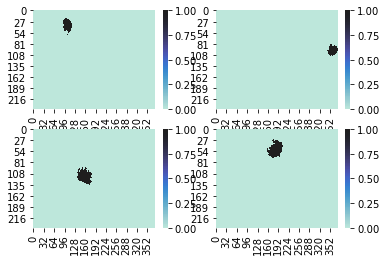

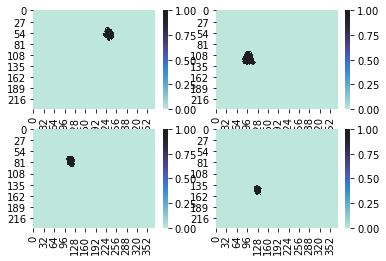

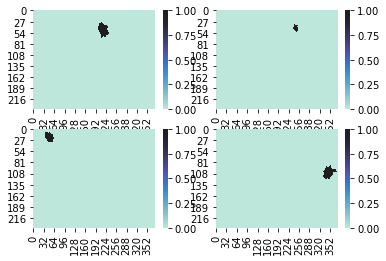

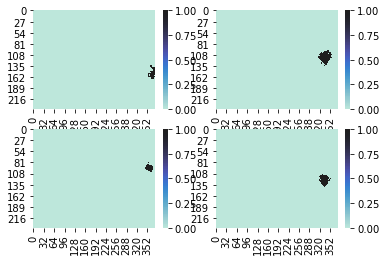

In [58]:
# Sanity check to see what neurons look like
# NB: seaborn is REALLY slow so you might want to not plot all the neurons at once.
cols = np.array(col_df)
rows = np.array(row_df)
neuron_positions = np.stack((rows,cols))

white_background = np.zeros((d1,d2))
amount_of_pixels = neuron_positions.shape[2]
# amount_of_neurons = neuron_positions.shape[1]
amount_of_neurons = 4
n = int(ceil(sqrt(amount_of_neurons))) # for the subplot dimensions

plt.figure(0)
for start in range(0,68,4):
    for i in range(start, start+amount_of_neurons):
        neuron_position = neuron_positions[:,i,:]
        neuron_position = neuron_position[~np.isnan(neuron_position)]
        amount_of_pixels = int(neuron_position.shape[0]/2)
        neuron_position = np.reshape(neuron_position, (2,amount_of_pixels))

        image_neuron = copy(white_background)
        for j in range(amount_of_pixels):
            row = int(neuron_position[0,j])
            col = int(neuron_position[1,j])
            image_neuron[row,col] = 1
        nr = i-start
        ax = plt.subplot2grid((n,n), (nr//n,nr%n))
        sns.heatmap(image_neuron, ax=ax, center=1)
    plt.show()

#### Fluorescence trace for each neuron(for plotting a timeseries of & for calculating cross-correlation)

In [46]:
# fluorescence traces == C (right??)
fluorescence_traces = np.array(data_after_CNMF_E['C'][0][0])

#### Cross correlation of Fluorescence trace (for checking if there might be duplicates)

In [53]:
correlation_matrix = np.corrcoef(fluorescence_traces)
correlation_matrix = np.absolute(correlation_matrix)

correlation_df = pd.DataFrame(correlation_matrix)
# Discard the lower left triangle as all correlation values will end up as doubles (includes the diagonal of 1.0's)
correlation_df = correlation_df.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
correlation_series = correlation_df.stack()
# correlations_sorted = correlation_series.sort_values(kind="quicksort") # this step is not necessary (any more)

highly_correlating_neurons = correlations_sorted[correlations_sorted>0.6]

<AxesSubplot:>

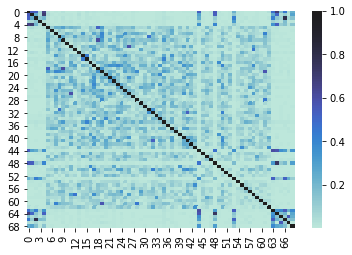

In [69]:
#plots for sanity check
sns.heatmap(correlation_matrix, center=1)

44  63    0.603746
9   18    0.610435
0   4     0.656312
    64    0.692525
1   4     0.709081
48  64    0.743148
2   66    0.804335
dtype: float64


<AxesSubplot:>

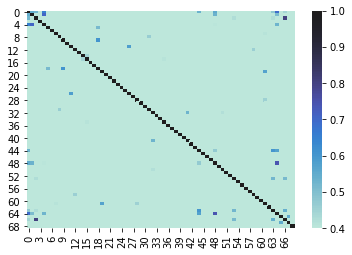

In [55]:
print(highly_correlating_neurons)
sns.heatmap(correlation_matrix, center=1, vmin=0.4)

In [63]:
double_selection_df = distance_df
double_selection_df['correlation'] = correlation_series.values
double_selection_df = double_selection_df[double_selection_df['distance'] < 10]
double_selection_df = double_selection_df[double_selection_df['correlation'] > 0.2]
double_selection_df

,neuron_1,neuron_2,distance,correlation
0,0,1,4.562129,0.547884
47,0,48,6.646510,0.553108
70,1,4,8.802322,0.709081
114,1,48,6.975530,0.531462
176,2,44,8.847159,0.248659
185,2,53,5.890072,0.424046
198,2,66,9.146555,0.804335
250,3,53,5.431773,0.326374
309,4,48,9.741390,0.405568
795,12,58,7.152226,0.457165


#### .tif video with cutout of each neuron (for showing a video of)

vmax:  100


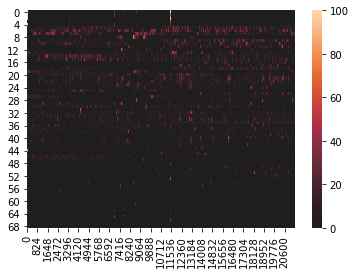

vmax:  50


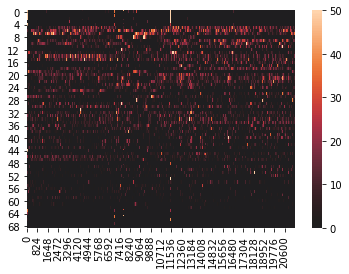

vmax:  40


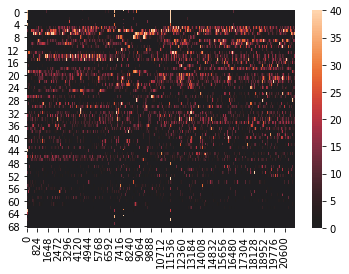

vmax:  30


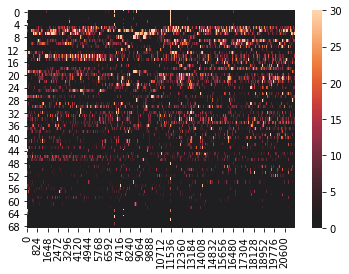

vmax:  25


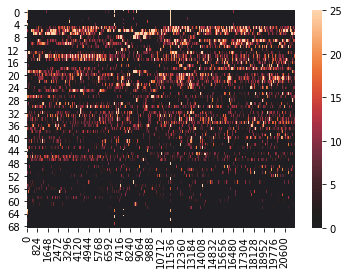

vmax:  20


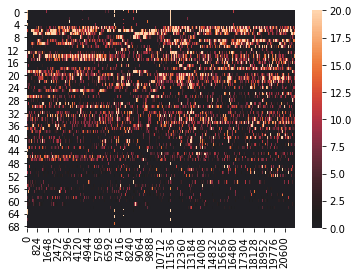

In [39]:
vmaxes= [100, 50, 40, 30, 25, 20]
for (i,vmax) in enumerate(vmaxes):
    print("vmax: " ,vmax)
    plt.figure(i)
    sns.heatmap(fluorescence_traces, center=1, vmax=vmax)
    plt.show()

In [72]:
import plotly.graph_objects as go 
print(fluorescence_traces.shape)
print(fluorescence_traces[7].shape)
x_axis = list(range(fluorescence_traces[7].shape[0]))
print(len(x_axis))
y_axis = list(fluorescence_traces[7])
print(len(y_axis))
figure = go.Figure(
            data = [go.Scatter(x = x_axis, y = y_axis, mode="lines")],
            layout = {"title": "A simple linechart"},
#             frames = [],
            )
figure.show()

(69, 21414)
(21414,)
21414
21414
